In [1]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json("C:/Users/mail4/Desktop/Soccermatics/wyscout/events/events_England.json")

In [3]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
#interruptions out
interruption = df.loc[df["eventName"] == "Interruption"]

# filter out non-accurate duels - in wyscout they are 2 way - attacking and defending
lost_duels = df.loc[df["eventName"] == "Duel"]
lost_duels = lost_duels.loc[lost_duels.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
df = df.drop(lost_duels.index)
# filter ball out of the field
out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_ball.index)
# save attempts can be dropped
goalies = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(goalies.index)

In [4]:
def isolateChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possesion chains

    """
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]
    #potential +0s
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    chain = 0
    df["possesion_chain"] = 0
    df["possesion_chain_team"] = 0

    for i, row in df.iterrows():
        #add value
        df.at[i, "possesion_chain"] = chain
        df.at[i, "possesion_chain_team"] = chain_team
        # if pass not accurate/lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                stop_criterion += 1
                #if ball intercepted properly add 2
        if row["eventName"] == "Others on the ball":
            if row["teamId"] == row["nextTeamId"]:
                stop_criterion += 2
        #if shot, add 2 to stop criteriom
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
            stop_criterion += 2
        #if shot from penalty or free kick, add 2
        if row["subEventName"] in ["Penalty", "Free kick shot"]:
            stop_criterion += 2
        #if ball out of field, add 2
        if row["kickedOut"] == 1:
            stop_criterion += 2
        #criterion for stopping when half ended
        if row["matchPeriod"] != period:
            chain += 1
            stop_criterion = 0
            chain_team = row['teamId']
            period = row["matchPeriod"]
            df.at[i, "possesion_chain"] = chain
            df.at[i, "possesion_chain_team"] = chain_team
        #possesion chain ended
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']
    return df

df = isolateChains(df)

In [5]:
def calulatexG(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with xG for each shot

    """
    #very basic xG model based on distance and angle
    shots_and_fk = df.loc[(df["eventName"] == "Shot") | (df["subEventName"] == "Free kick shot")].copy()
    shots_and_fk["X"] = shots_and_fk.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots_and_fk["Y"] = shots_and_fk.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots_and_fk["C"] = shots_and_fk.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle
    shots_and_fk["Distance"] = np.sqrt(shots_and_fk["X"]**2 + shots_and_fk["C"]**2)
    shots_and_fk["Angle"] = np.where(np.arctan(7.32 * shots_and_fk["X"] / (shots_and_fk["X"]**2 + shots_and_fk["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots_and_fk["X"] /(shots_and_fk["X"]**2 + shots_and_fk["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots_and_fk["X"] /(shots_and_fk["X"]**2 + shots_and_fk["C"]**2 - (7.32/2)**2)) + np.pi)

    shots_and_fk["Goal"] = shots_and_fk.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    #headers have id = 403
    headers = shots_and_fk.loc[shots_and_fk.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    nh_and_fk = shots_and_fk.drop(headers.index)
    freekick_shots = nh_and_fk.loc[nh_and_fk["subEventName"] == "Free kick shot"]
    non_headers = nh_and_fk.drop(freekick_shots.index)

    # calculate xg model for headers
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers,
                            family=sm.families.Binomial()).fit()
    # calculate xg model for non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers,
                               family=sm.families.Binomial()).fit()
    #assigning xG
    df["xG"] = 0.0
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)
    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]
    #non-headers
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)
    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    #penalties
    penalties = df.loc[df["subEventName"] == "Penalty"]
    xG = len(penalties.loc[penalties.apply(lambda x :{'id':101} in x.tags, axis=1)])/len(penalties)
    penalties = penalties.assign(xG = xG)
    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]

    # calculate xg model for free kicks
    fk_model = smf.glm(formula="Goal ~ Distance + Angle" , data=freekick_shots,
                            family=sm.families.Binomial()).fit()
    b_fks = fk_model.params
    xG = 1/(1+np.exp(b_fks[0]+b_fks[1]*freekick_shots['Distance'] + b_fks[2]*freekick_shots['Angle']))
    freekick_shots = freekick_shots.assign(xG = xG)
    for index, row in freekick_shots.iterrows():
        df.at[index,"xG"] = row["xG"]
    return df

df = calulatexG(df)

In [6]:
df.loc[df["possesion_chain"] == 834]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,nextTeamId,possesion_chain,possesion_chain_team,xG
4848,7,Touch,[{'id': 1401}],14748,"[{'y': 44, 'x': 8}, {'y': 46, 'x': 29}]",2499721,Others on the ball,1610,2H,2667.011870,72,178123596,Ground defending duel,0,1646,834,1610,0.0
4850,1,Ground attacking duel,"[{'id': 703}, {'id': 1801}]",8980,"[{'y': 54, 'x': 71}, {'y': 55, 'x': 73}]",2499721,Duel,1646,2H,2670.728036,11,178123621,Simple pass,0,1646,834,1610,0.0
4851,8,Simple pass,[{'id': 1801}],8980,"[{'y': 55, 'x': 73}, {'y': 21, 'x': 71}]",2499721,Pass,1646,2H,2672.007066,85,178123622,Simple pass,0,1646,834,1610,0.0


In [7]:
df.loc[(df["subEventName"]=="Free kick shot")]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,nextTeamId,possesion_chain,possesion_chain_team,xG
2084,3,Free kick shot,"[{'id': 402}, {'id': 1101}, {'id': 201}, {'id'...",38021,"[{'y': 33, 'x': 76}, {'y': 100, 'x': 100}]",2499720,Free Kick,1625,1H,995.894670,33,178147638,Save attempt,0,1625,371,1625,0.051143
2254,3,Free kick shot,"[{'id': 402}, {'id': 1101}, {'id': 2101}, {'id...",38021,"[{'y': 29, 'x': 77}, {'y': 100, 'x': 100}]",2499720,Free Kick,1625,1H,1873.311156,33,178147796,Clearance,0,1651,401,1625,0.053282
4475,3,Free kick shot,"[{'id': 401}, {'id': 1101}, {'id': 201}, {'id'...",8032,"[{'y': 64, 'x': 72}, {'y': 0, 'x': 0}]",2499721,Free Kick,1610,2H,951.436722,33,178123230,Save attempt,0,1610,765,1610,0.050354
4846,3,Free kick shot,"[{'id': 401}, {'id': 1101}, {'id': 201}, {'id'...",9623,"[{'y': 49, 'x': 83}, {'y': 100, 'x': 100}]",2499721,Free Kick,1646,2H,2664.038744,33,178123617,Shot,0,1646,832,1646,0.036719
6152,3,Free kick shot,"[{'id': 401}, {'id': 1101}, {'id': 201}, {'id'...",454,"[{'y': 54, 'x': 70}, {'y': 0, 'x': 0}]",2499722,Free Kick,1628,2H,1715.579428,33,178205147,Ball out of the field,1,1673,1069,1628,0.048866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637321,3,Free kick shot,"[{'id': 401}, {'id': 1101}, {'id': 2101}, {'id...",245364,"[{'y': 63, 'x': 79}, {'y': 100, 'x': 100}]",2500095,Free Kick,1625,1H,1692.455205,33,251543139,Touch,0,1619,112618,1625,0.047857
638653,3,Free kick shot,"[{'id': 402}, {'id': 1101}, {'id': 2101}, {'id...",25571,"[{'y': 39, 'x': 79}, {'y': 0, 'x': 0}]",2500096,Free Kick,10531,1H,786.233932,33,251666575,Touch,0,1639,112864,10531,0.046594
639195,3,Free kick shot,"[{'id': 402}, {'id': 1101}, {'id': 201}, {'id'...",25571,"[{'y': 37, 'x': 77}, {'y': 0, 'x': 0}]",2500096,Free Kick,10531,1H,2587.108567,33,251666895,Ball out of the field,1,1639,112963,10531,0.048858
641499,3,Free kick shot,"[{'id': 402}, {'id': 1101}, {'id': 1215}, {'id...",8717,"[{'y': 27, 'x': 83}, {'y': 0, 'x': 0}]",2500097,Free Kick,1624,2H,2342.553411,33,251621609,Ball out of the field,1,1631,113376,1624,0.056438


In [8]:
def prepareChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with assigned values for chains

    """
    df["shot_end"] = 0
    #get number of chains
    no_chains = max(df["possesion_chain"].unique())
    indicies = []
    for i in range(no_chains+1):
        #all events get possesion chain
        possesion_chain_df = df.loc[df["possesion_chain"] == i]
        #check if the possesion chain is not empty
        if len(possesion_chain_df) > 0:
            #if ended with shot
            if possesion_chain_df.iloc[-1]["eventName"] == "Shot" or possesion_chain_df.iloc[-1]["subEventName"] in ["Penalty","Free kick shot"]:
                #assign values
                df.loc[df["possesion_chain"] == i, "shot_end"] = 1
                xG = possesion_chain_df.iloc[-1]["xG"]
                df.loc[df["possesion_chain"] == i, "xG"] = xG
                #check if the previous ones did not end with foul
                k = i-1
                if k > 0:
                    try:
                        prev = df.loc[df["possesion_chain"] == k]
                        #create a loop if e.g. 2 chains before and 1 chain before didn;t end with shot
                        while prev.iloc[-1]["eventName"] == "Foul":
                            #assign value for them
                            df.loc[df["possesion_chain"] == k, "xG"] = xG
                            df.loc[df["possesion_chain"] == k, "shot_end"] = 1
                            k = k-1
                            prev = df.loc[df["possesion_chain"] == k]
                    except:
                        k = k-1
            #get indiices of events made by possesion team
            team_indicies = possesion_chain_df.loc[possesion_chain_df["teamId"] == possesion_chain_df.teamId.mode().iloc[0]].index.values.tolist()
            indicies.extend(team_indicies)

    df = df.loc[indicies]
    return df

df = prepareChains(df)

In [10]:
#filter out dodgy
df = df.loc[df.apply(lambda x: len(x.positions) == 2, axis = 1)]
#columns with coordinates
df["x0"] = df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
df["c0"] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68/100)
df["x1"] = df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
df["c1"] = df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68/100)
#assign (105, 0) to end of the shot
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "c1"] = 0

df.loc[df["subEventName"] == "Free kick shot", "x1"] = 105
df.loc[df["subEventName"] == "Free kick shot", "c1"] = 0

df.loc[df["subEventName"] == "Penalty", "x1"] = 105
df.loc[df["subEventName"] == "Penalty", "c1"] = 0

#for plotting
df["y0"] = df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
df["y1"] = df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
df.loc[df["eventName"] == "Shot", "y1"] = 34
df.loc[df["subEventName"] == "Free kick shot", "y1"] = 34
df.loc[df["subEventName"] == "Penalty", "y1"] = 34

In [11]:
df.to_csv("prepared_chains.csv")

In [2]:
df = pd.read_csv("prepared_chains.csv")

In [3]:
from itertools import combinations_with_replacement

#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df[c]
        #create a new column in df
        df[column] = x
        #add column to model variables
        var.append(column)

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

passes = df.loc[ df["eventName"].isin(["Pass"])]
X_p = passes[var].values
y_p = passes["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size = 0.1, random_state = 123, stratify = y_p)
xgb_p = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
                   random_state=123)
xgb_p.fit(X_train, y_train)

fk_cross = df.loc[ df["subEventName"].isin(["Free kick cross"])]
X_fk = fk_cross[var].values
y_fk = fk_cross["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X_fk, y_fk, test_size = 0.1, random_state = 123, stratify = y_fk)
xgb_fk = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
                     random_state=123)
xgb_fk.fit(X_train, y_train)

[17:12:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ccp_alpha", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:13:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ccp_alpha", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None, ccp_alpha=0,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             min_samples_leaf=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=123, ...)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

ground_duels = df.loc[ df["eventName"].isin(["Pass"])]
X_p = passes[var].values
y_p = passes["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size = 0.1, random_state = 123, stratify = y_p)
xgb_p = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
                     random_state=123)
xgb_p.fit(X_train, y_train)

In [26]:
from sklearn.linear_model import LinearRegression

#predict probability of shot ended
y_pred_proba = xgb_p.predict(X_p)

passes["shot_prob"] = y_pred_proba
#OLS
shot_ended = passes.loc[passes["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X_p)
passes["xG_pred"] = y_pred
#calculate xGchain
passes["xT"] = passes["xG_pred"]*passes["shot_prob"]

# now again for passes from free kicks
#predict probability of shot ended
y_pred_proba = xgb_p.predict(X_fk)

fk_cross["shot_prob"] = y_pred_proba
#OLS
shot_ended = fk_cross.loc[fk_cross["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X_fk)
fk_cross["xG_pred"] = y_pred
#calculate xGchain
fk_cross["xT"] = fk_cross["xG_pred"]*fk_cross["shot_prob"]

In [27]:
passes.to_csv("passes_xT.csv")
fk_cross.to_csv("fk_cross_xT.csv")

In [28]:
passes

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1,shot_prob,xG_pred,xT
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,15.05112,421.43136,11800.07808,0.314432,8.804096,246.514688,6902.411264,0.046361,0.130979,0.006072
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,19413.03168,17333.06400,15475.95000,6902.411264,6162.867200,5502.560000,4913.000000,0.045672,0.113253,0.005172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,10620.75000,8921.43000,7494.00120,4913.000000,4126.920000,3466.612800,2911.954752,0.047104,0.124779,0.005878
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,8778.68712,18811.47240,40310.29800,2911.954752,6239.903040,13371.220800,28652.616000,0.034652,0.123084,0.004265
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,70788.81600,59777.22240,50478.54336,28652.616000,24195.542400,20431.791360,17253.512704,0.038159,0.116570,0.004448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,...,5005.22568,17710.79856,62668.97952,690.807104,2444.394368,8649.395456,30605.553152,0.076510,0.112181,0.008583
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,...,41094.41280,31267.48800,23790.48000,30605.553152,23286.833920,17718.243200,13481.272000,0.050404,0.138252,0.006968
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,...,10293.02400,20071.39680,39139.22376,2515.456000,4905.139200,9565.021440,18651.791808,0.064706,0.120468,0.007795
643142,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,2785.702032,...,73109.11608,41241.03984,23264.17632,18651.791808,10521.523584,5935.218432,3348.071936,0.102032,0.171192,0.017467


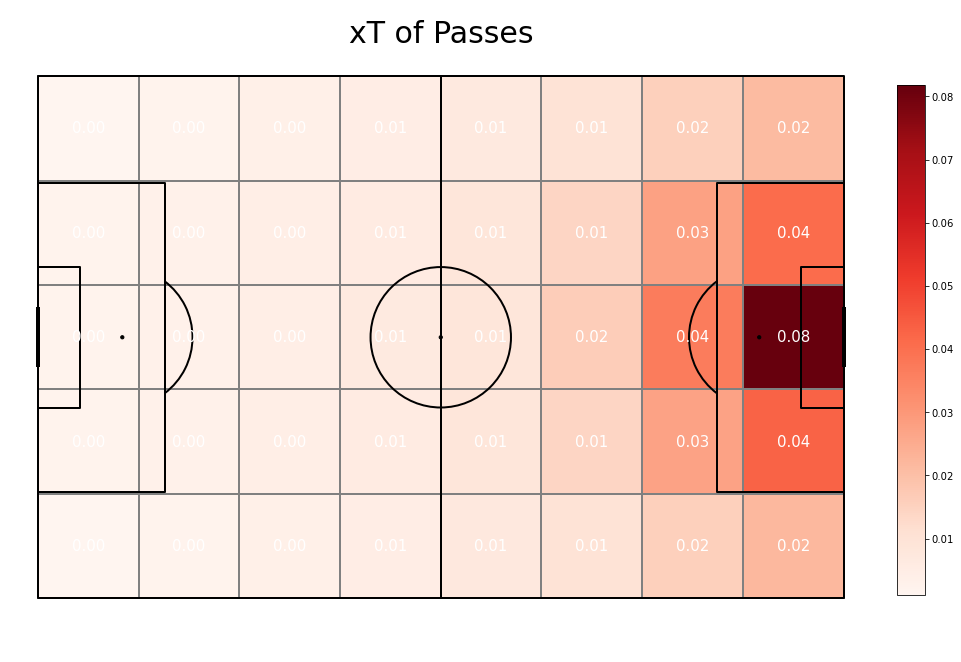

In [57]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
passing = pitch.bin_statistic(passes["x0"], passes["y0"], values=passes["xT"], statistic='mean', bins=(8, 5), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(passing, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
labels = pitch.label_heatmap(passing, color='white', fontsize=15,
                                                      ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xT of Passes', fontsize = 30)
plt.show()


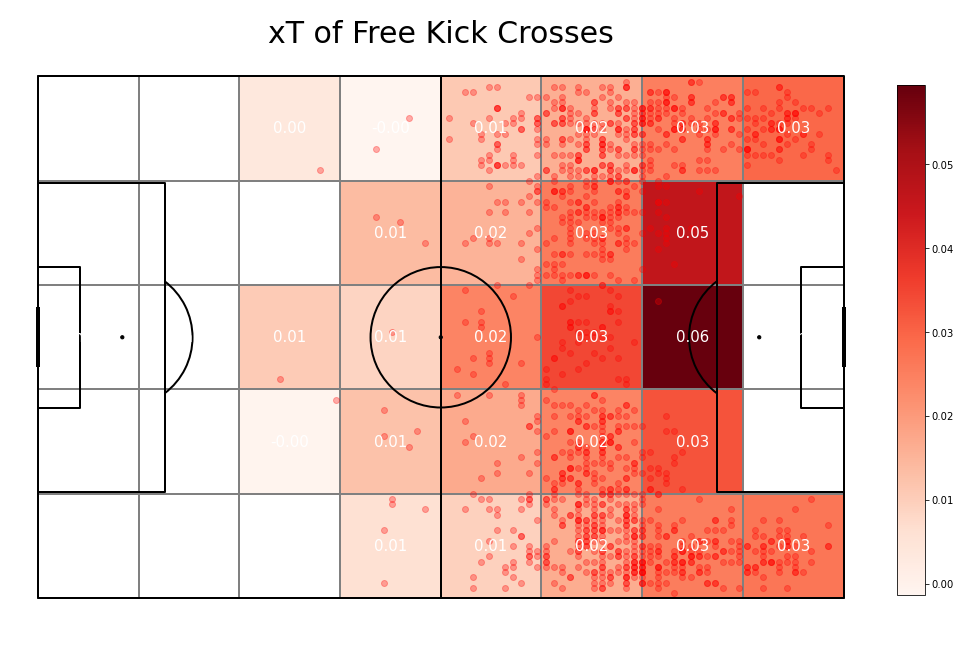

In [58]:
fk_crossing = pitch.bin_statistic(fk_cross["x0"], fk_cross["y0"], values=fk_cross["xT"], statistic='mean', bins=(8, 5), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(fk_crossing, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
sc = pitch.scatter(fk_cross.x0, fk_cross.y0, color="r", alpha = 0.3, ax = ax['pitch'])
labels = pitch.label_heatmap(fk_crossing, color='white', fontsize=15,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xT of Free Kick Crosses', fontsize = 30)
plt.show()

In [44]:
np.nan_to_num(fk_crossing["statistic"])

array([[ 0.        ,  0.        ,  0.00355532, -0.00125766,  0.01111068,
         0.01626848,  0.02508081,  0.02945787],
       [ 0.        ,  0.        ,  0.        ,  0.01384477,  0.01552765,
         0.02564946,  0.04637135,  0.        ],
       [ 0.        ,  0.        ,  0.01071273,  0.00885134,  0.02420273,
         0.03461362,  0.05941068,  0.        ],
       [ 0.        ,  0.        , -0.00058933,  0.01268292,  0.01705574,
         0.02421221,  0.03281003,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.00628532,  0.00959913,
         0.01663397,  0.02539658,  0.02693572]])

In [ ]:
xt_diff = np.nan_to_num(fk_crossing["statistic"])-passing["statistic"]
fk_crossing["statistic"] = xt_diff

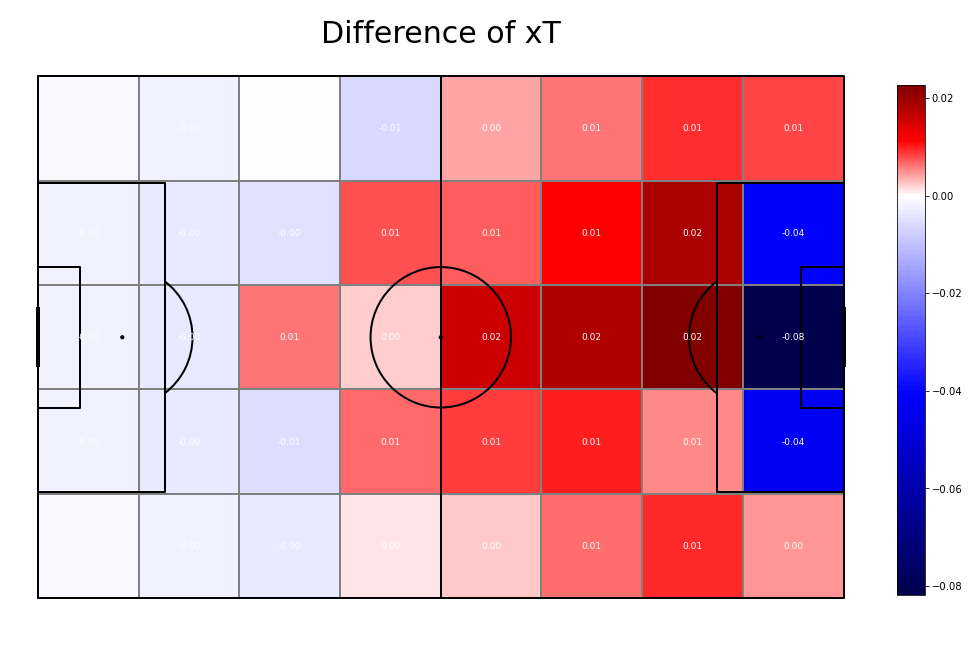

In [48]:
from matplotlib import colors

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(fk_crossing, cmap='seismic', edgecolor='grey',norm=colors.TwoSlopeNorm(vcenter=0.), ax=ax['pitch'])
labels = pitch.label_heatmap(fk_crossing, color='white', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Difference of xT', fontsize = 30)
plt.show()

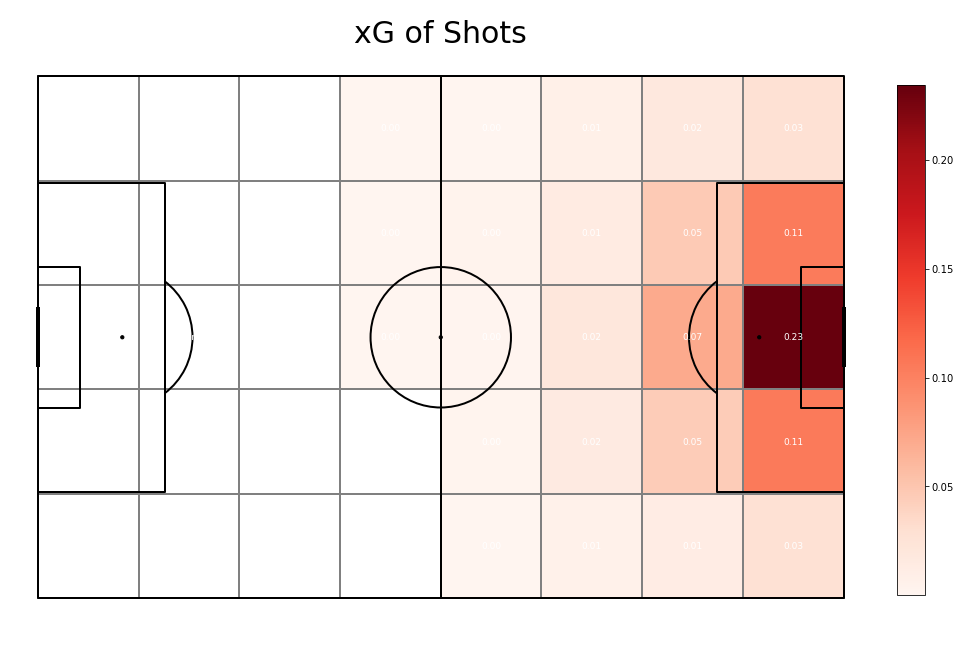

In [75]:
shots = df.loc[df["eventName"] == "Shot"]
shooting = pitch.bin_statistic(shots["x0"], shots["y0"], values=shots["xG"], statistic='mean', bins=(8, 5), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shooting, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
labels = pitch.label_heatmap(shooting, color='white', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xG of Shots', fontsize = 30)
plt.show()

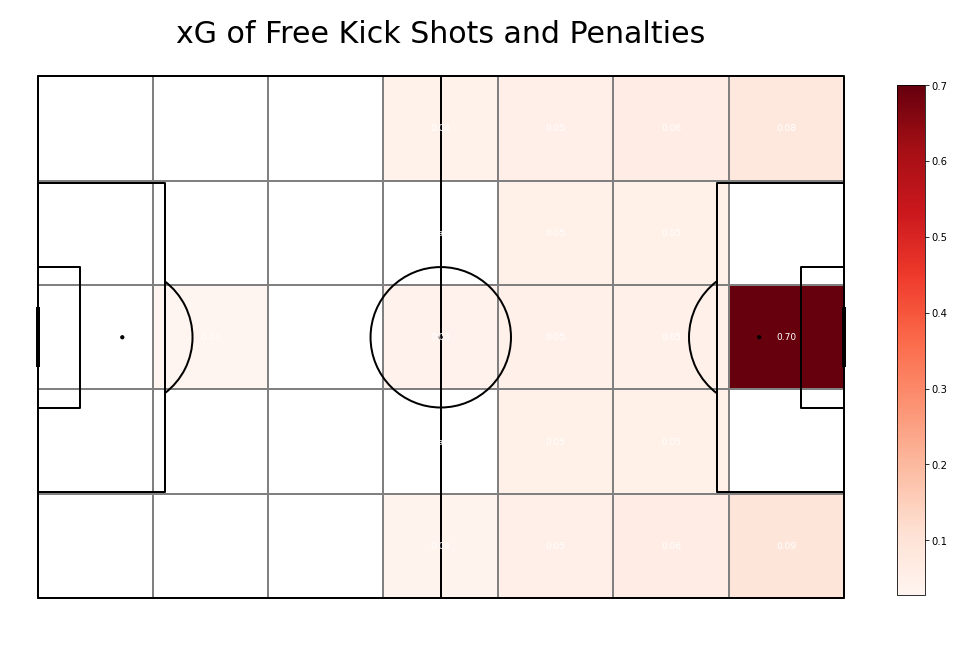

In [70]:
set_pieces = df.loc[(df["subEventName"] == "Free kick shot") | (df["subEventName"] == "Penalty")]
set_piece_shots = pitch.bin_statistic(set_pieces["x0"], set_pieces["y0"], values=set_pieces["xG"], statistic='mean', bins=(7, 5), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(set_piece_shots, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
labels = pitch.label_heatmap(set_piece_shots, color='white', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xG of Free Kick Shots and Penalties', fontsize = 30)
plt.show()

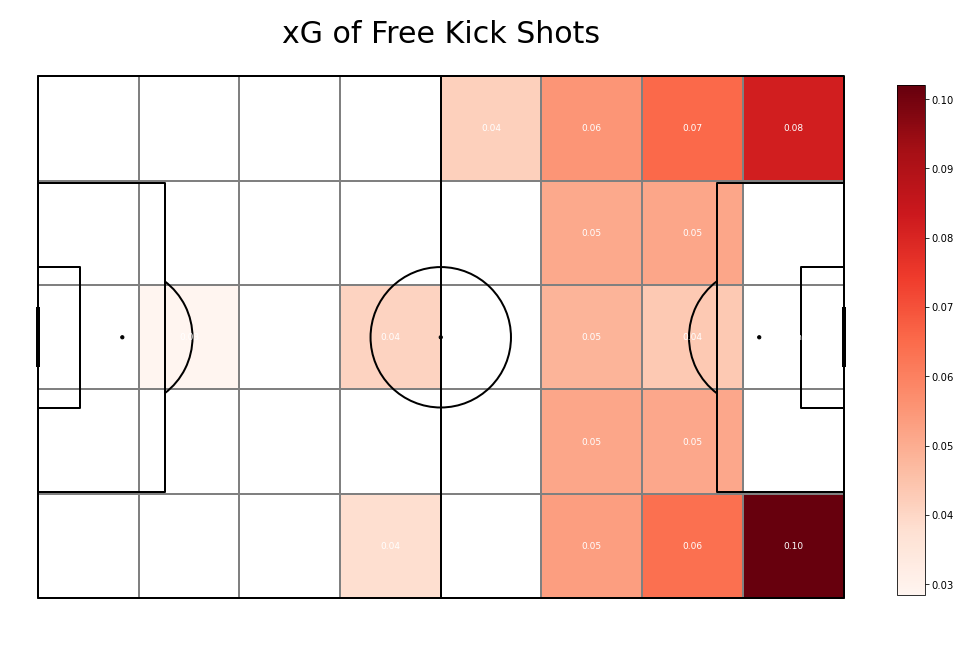

In [76]:
set_pieces = df.loc[(df["subEventName"] == "Free kick shot")]
set_piece_shots = pitch.bin_statistic(set_pieces["x0"], set_pieces["y0"], values=set_pieces["xG"], statistic='mean', bins=(8, 5), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(set_piece_shots, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
labels = pitch.label_heatmap(set_piece_shots, color='white', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xG of Free Kick Shots', fontsize = 30)
plt.show()

In [77]:
xg_diff = np.nan_to_num(set_piece_shots["statistic"])-np.nan_to_num(shooting["statistic"])
shooting["statistic"] = xg_diff

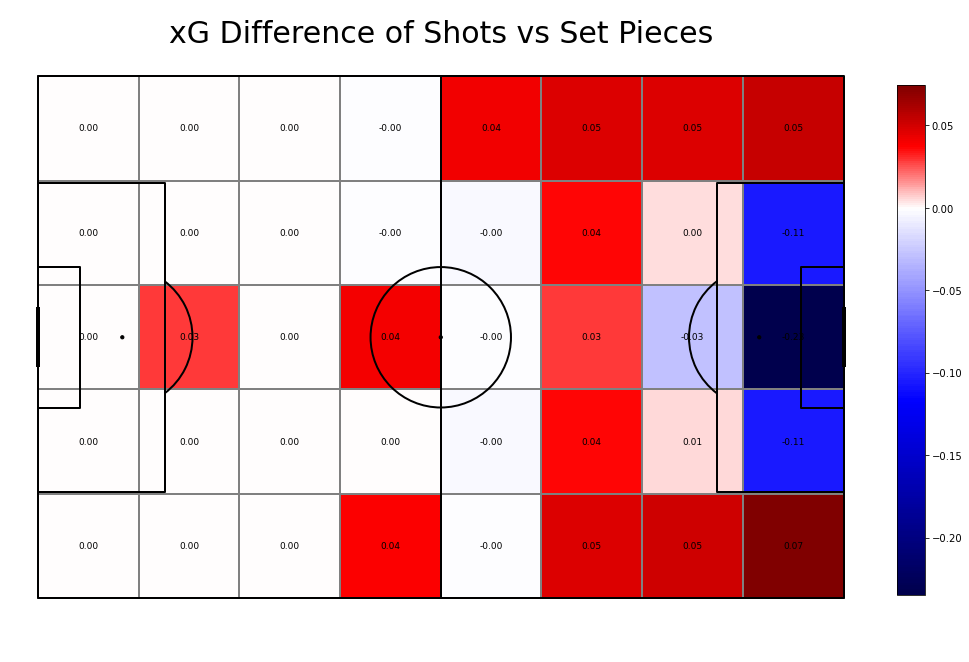

In [78]:
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shooting, cmap='seismic', edgecolor='grey',norm=colors.TwoSlopeNorm(vcenter=0.), ax=ax['pitch'])
labels = pitch.label_heatmap(shooting, color='black', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xG Difference of Shots vs Set Pieces', fontsize = 30)
plt.show()

In [ ]:
fk_indices = []
pen_indices = []
for i in range(max(df["possesion_chain"].unique())+1):
    possesion_chain_df = df.loc[df["possesion_chain"] == i]
    #check if the possesion chain is not empty
    if len(possesion_chain_df) > 0:
        #if ended with shot
        if possesion_chain_df.iloc[0]["subEventName"] in ["Free kick shot", "Free kick cross"]:
            fk_indices.append(i)
        if possesion_chain_df.iloc[0]["subEventName"] == "Penalty":
            pen_indices.append(i)
df_pen = df.loc["possesion_chain" in pen_indices]
df_fk = df.loc["possesion_chain" in fk_indices]
df_rest = df.drop[df_pen.index]
df_rest = df_rest.drop[df_fk.index]